# Image segmentation with SAM

Image segmentation consists of the breakdown or partition of a given image by generating masks for the different objects or parts of the image. For this task, Meta's Segment Anything Model (SAM) algorithm is used, which was trained with millions of images.

Sources: 

https://github.com/facebookresearch/segment-anything

https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb

In [1]:
# Installing special libraries

#!pip install opencv-python
#!pip install torch
#!pip install torchvision
#!pip install segment-anything

In [2]:
# Importing libraries

import numpy as np
import matplotlib.pyplot as plt

import cv2
import torch
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry, SamPredictor

## Image

<class 'numpy.ndarray'>


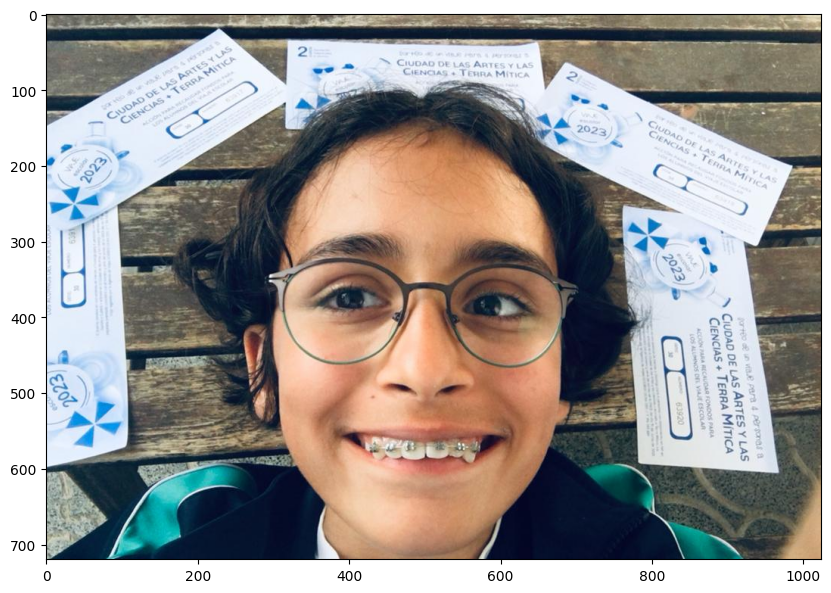

In [3]:
# Image to be segmented

image = cv2.imread('Data/Ori.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(type(image))

plt.figure(figsize=(10, 10))
plt.imshow(image)
# plt.axis('off')
plt.show()

## Mask generator

In [4]:
# Type of model
model_type = "vit_h"

# Checkpoint file, previously downloaded from: https://github.com/facebookresearch/segment-anything#model-checkpoints
sam_checkpoint = "sam_vit_h_4b8939.pth"

# Nodel initialization
sam_model = sam_model_registry[model_type](checkpoint=sam_checkpoint)

# Automatic mask generator
masks = SamAutomaticMaskGenerator(sam_model).generate(image)

## Show me the masks

In [5]:
# Function to show the segmentation masks on the given image

def show_masks(masks):
    if len(masks) == 0:
        return
    
    sorted_masks = sorted(masks, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_masks[0]['segmentation'].shape[0], sorted_masks[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for mask in sorted_masks:
        m = mask['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [6]:
# Information on masks

print(type(masks))
print(len(masks))
print(masks[0].keys())

<class 'list'>
89
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


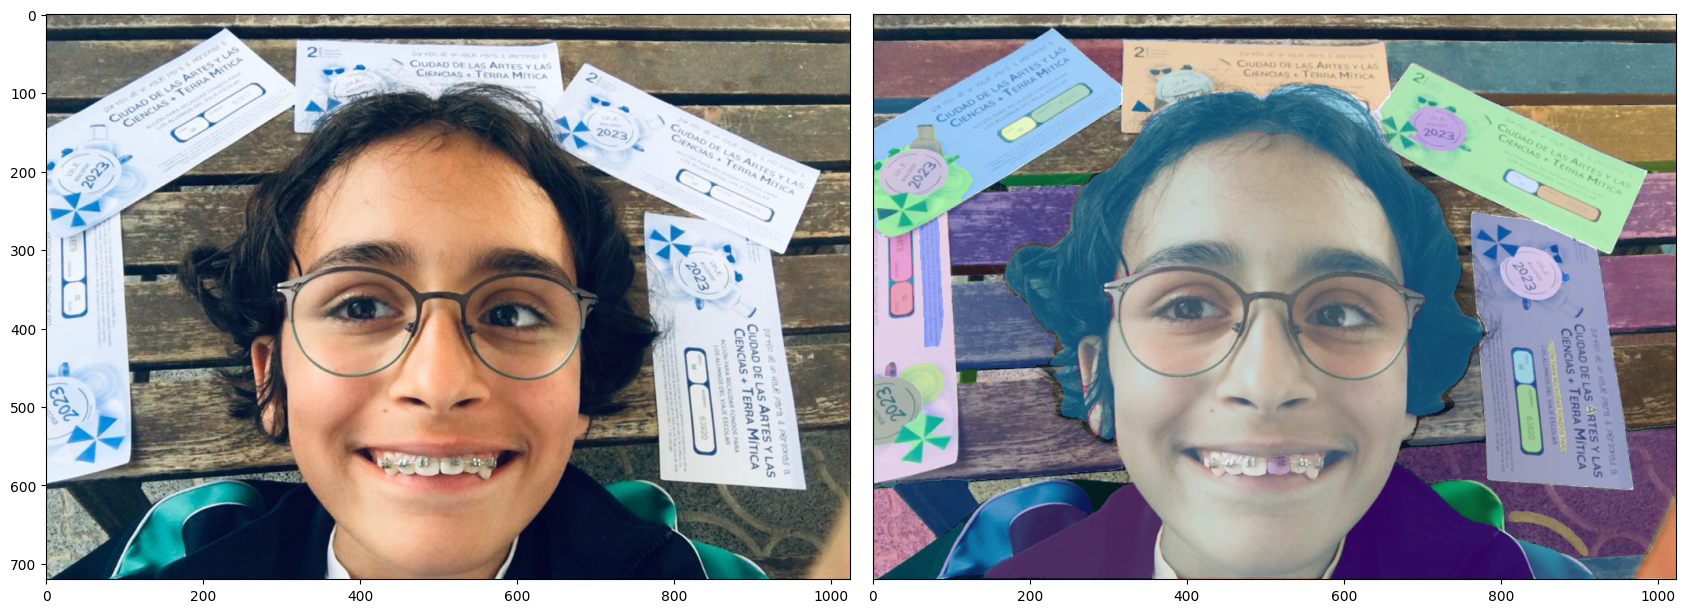

In [7]:
# Plotting the image and segmented image with masks

plt.figure(figsize=(17, 17))

plt.subplot(121)
plt.imshow(image)

plt.subplot(122)
plt.imshow(image)
show_masks(masks)
plt.tick_params(axis='y', which='both', left=False, labelleft=False)
# plt.axis('off')

plt.tight_layout()
plt.show() 

## Masks

In [8]:
# Mask structure

masks[0]['segmentation']

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

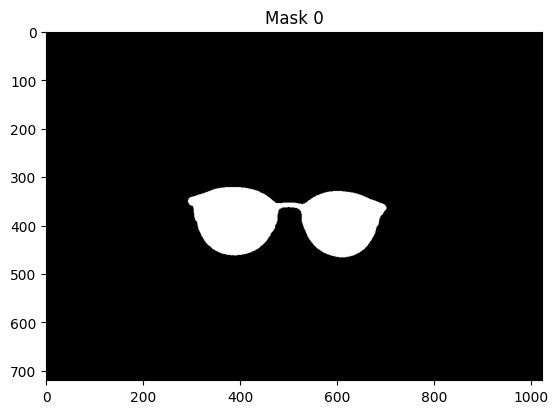

<module 'matplotlib.pyplot' from 'C:\\Python311\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [9]:
# Converting boolean array into integer array (0 and 255)

mask_np = masks[0]['segmentation'].astype(np.uint8) * 255

# Plotting the first mask

plt.imshow(mask_np, cmap='gray')
plt.title('Mask 0')
plt.show()
plt

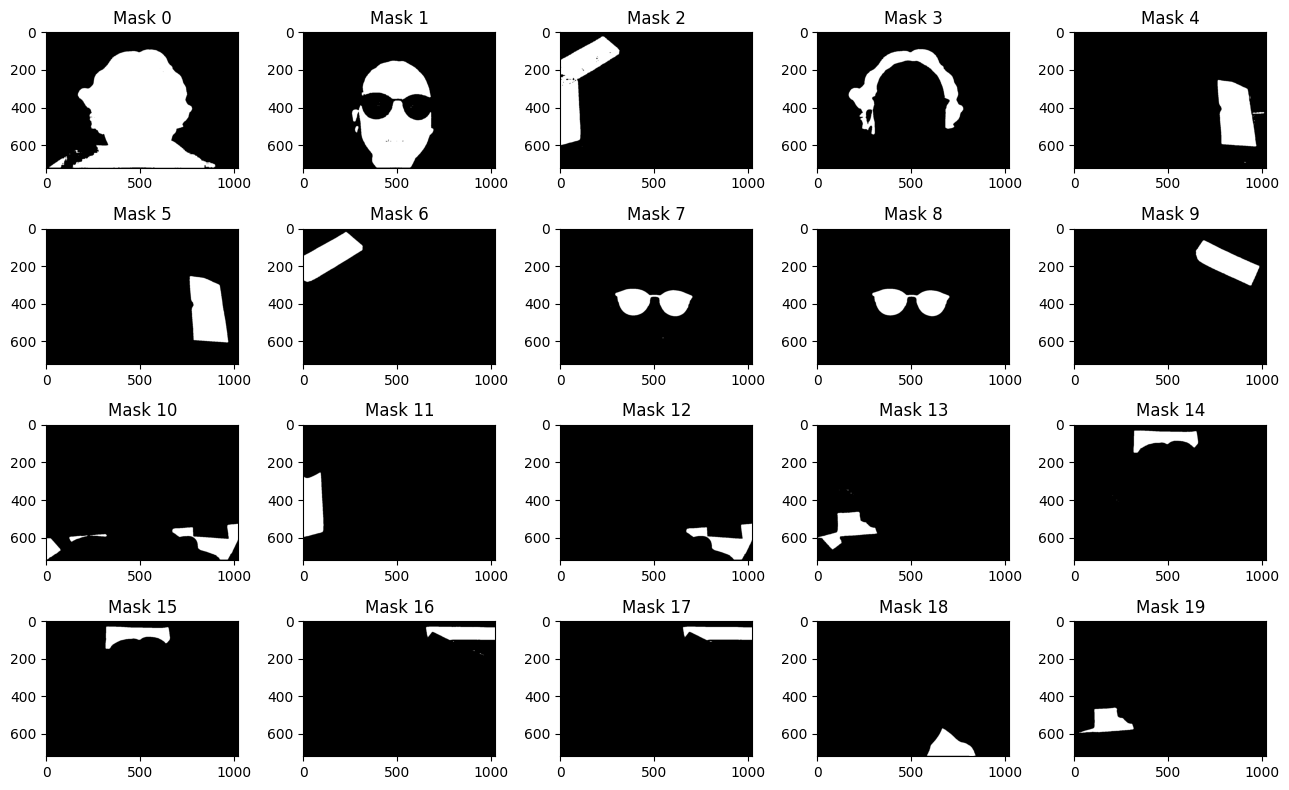

In [10]:
# Plotting the 20 bigest masks by area

sorted_masks = sorted(masks, key=(lambda x: x['area']), reverse=True)

plt.figure(figsize=(13, 8))

for i in range(0, 20):
    plt.subplot(4, 5, i+1)
    plt.imshow(sorted_masks[i]['segmentation'].astype(np.uint8) * 255, cmap='gray')
    plt.title('Mask '+str(i))

plt.tight_layout()
plt.show()   

# Tunning the mask generator

In [12]:
# Tunning the mask generator

masks2 = SamAutomaticMaskGenerator(
    model=sam_model,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
).generate(image)

## Show me the masks

In [13]:
# Information on masks2

print(type(masks2))
print(len(masks2))
print(masks2[0].keys())

<class 'list'>
131
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


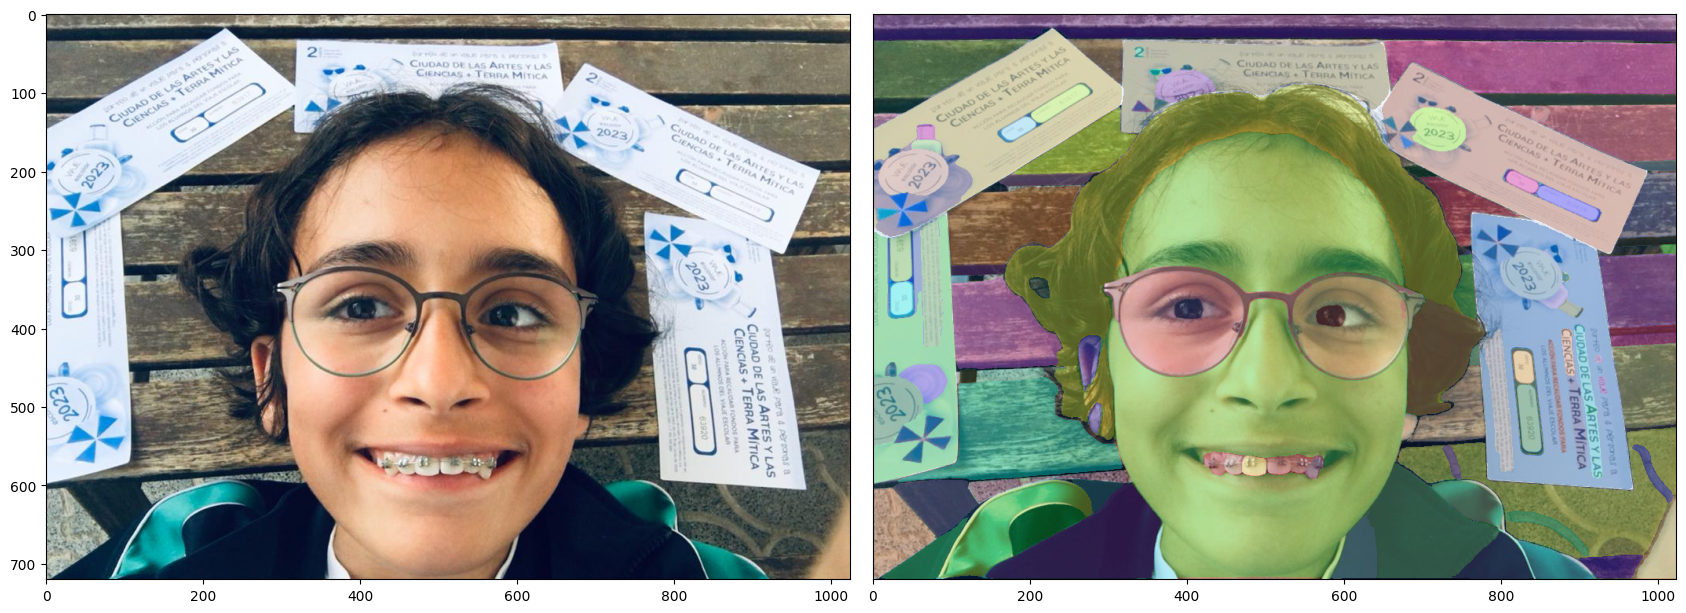

In [14]:
# Plotting the image and segmented image with new masks

plt.figure(figsize=(17, 17))

plt.subplot(121)
plt.imshow(image)

plt.subplot(122)
plt.imshow(image)
show_masks(masks2)
plt.tick_params(axis='y', which='both', left=False, labelleft=False)
# plt.axis('off')

plt.tight_layout()
plt.show() 

# Segmenting by single point

In [15]:
# Single point (pront)

input_point = np.array([[400, 400]])
input_label = np.array([1])

In [16]:
# Function for pronts (points and rectangle) and corresponding masks

def show_point_masks(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

## Predictor generator

In [17]:
# Type of model
model_type = "vit_h"

# Checkpoint file, previously downloaded from: https://github.com/facebookresearch/segment-anything#model-checkpoints
sam_checkpoint = "sam_vit_h_4b8939.pth"

# Nodel initialization
sam_model = sam_model_registry[model_type](checkpoint=sam_checkpoint)

# Automatic mask generator
masks = SamAutomaticMaskGenerator(sam_model).generate(image)

In [18]:
# Inicialization of the predictor
predictor = SamPredictor(sam_model)
predictor.set_image(image)

# Prediction generation
mask_points, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True
)

## Show me the masks

In [19]:
# Information on masks_points

print(type(mask_points))
mask_points.shape  # (number_of_masks) x H x W

<class 'numpy.ndarray'>


(3, 720, 1024)

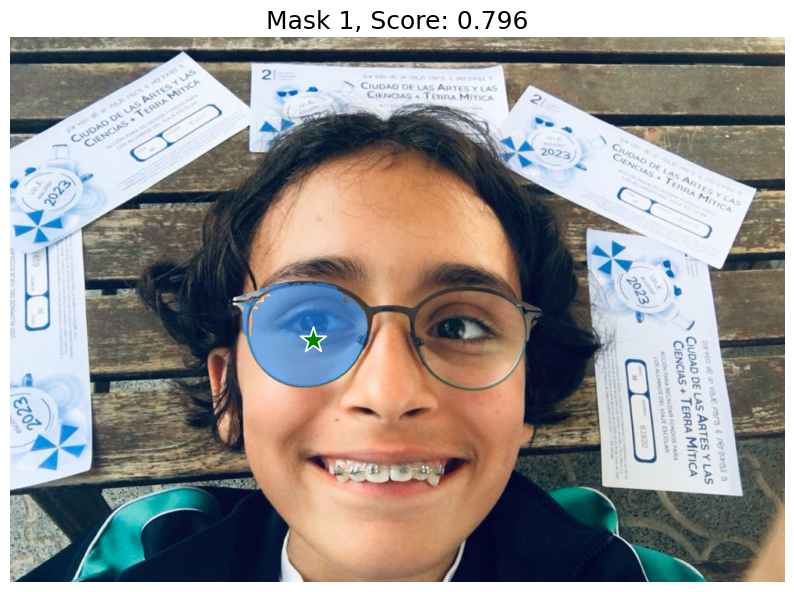

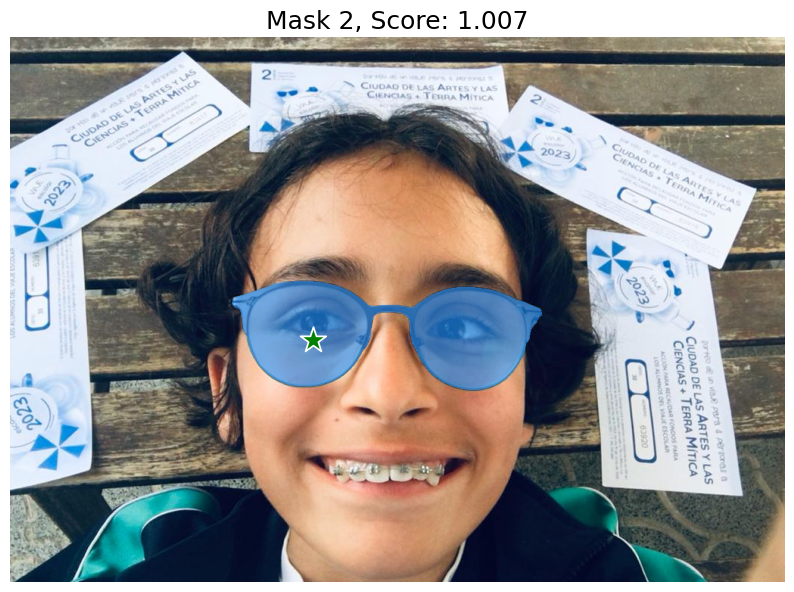

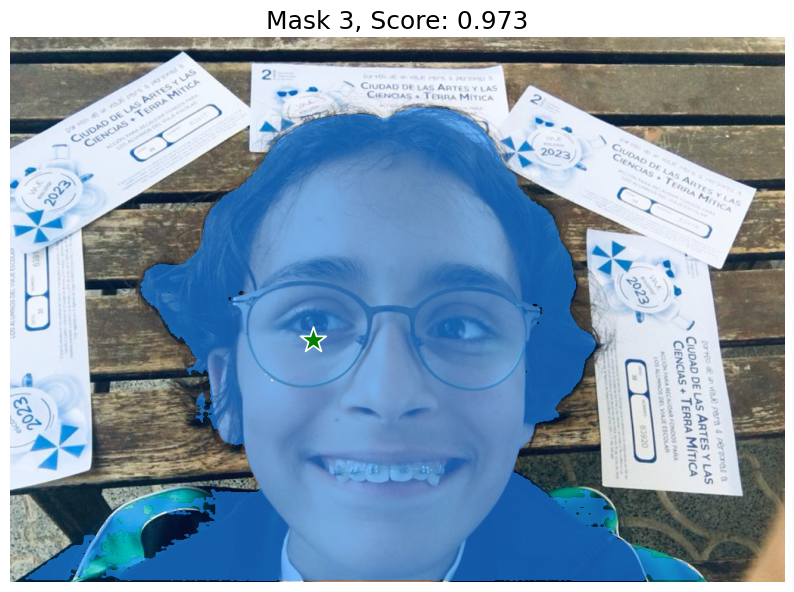

In [20]:
# Plotting 3 solutions for the same point. Higher the score the better

for i, (mask, score) in enumerate(zip(mask_points, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_point_masks(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show() 

# Segmenting by several point

In [21]:
# Several points (pront)

input_points = np.array([[20, 400], [820, 400]])

# Segmenting with a point generates a good mask, red star point is ignored
input_label = np.array([1, 0])
# input_label = np.array([0, 1])

# Segmenting with two points generates bad masks
# input_label = np.array([1, 1])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

## Predictor generator

In [22]:
mask_points2, _, _ = predictor.predict(
    point_coords=input_points,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

## Show me the masks

In [23]:
# Information on masks_points2

print(type(mask_points2))
mask_points2.shape

<class 'numpy.ndarray'>


(1, 720, 1024)

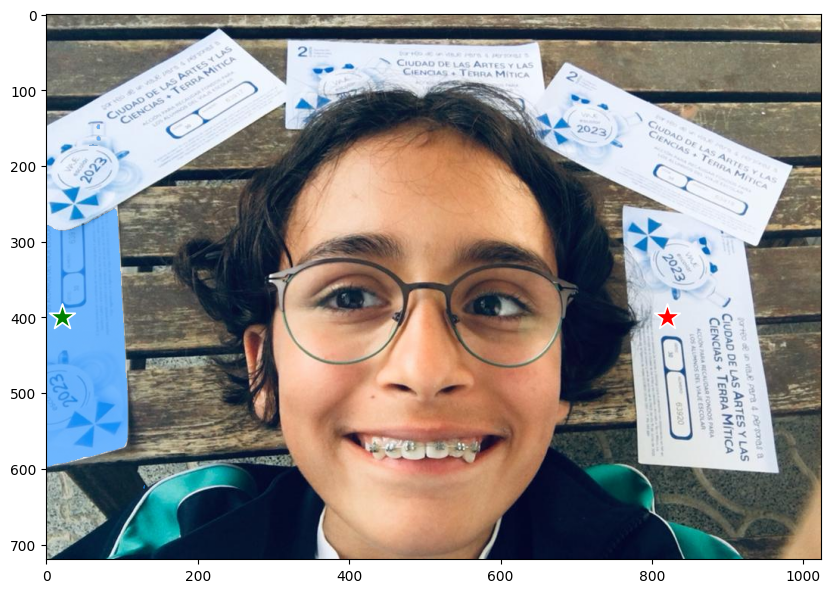

In [24]:
# Plotting the mask for one point

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_point_masks(mask_points2, plt.gca())
show_points(input_points, input_label, plt.gca())
# plt.axis('off')
plt.show() 

# Segmenting by rectangle

In [25]:
# Rectangle (pront)

input_box = np.array([270, 310, 710, 480])
# input_point = np.array([[400, 400]])
input_label = np.array([0])

## Predictor generator

In [26]:
mask_points3, _, _ = predictor.predict(
#     point_coords=input_point,
    point_labels=input_label,
    box=input_box,
    multimask_output=False,
)

## Show me the masks

In [27]:
# Information on masks_points3

print(type(mask_points3))
mask_points3.shape

<class 'numpy.ndarray'>


(1, 720, 1024)

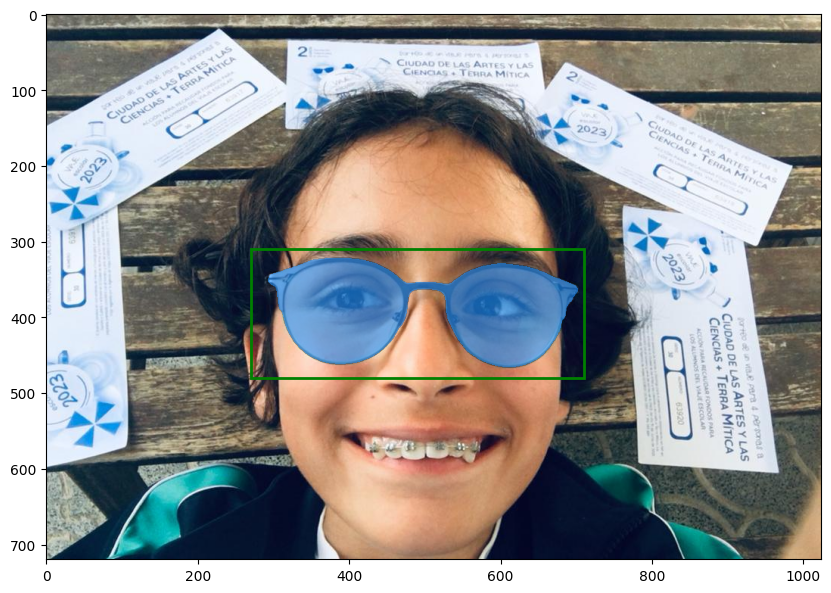

In [28]:
# Plotting the mask for the given rectangle

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_point_masks(mask_points3[0], plt.gca())
show_box(input_box, plt.gca())
# show_points(input_point, input_label, plt.gca())
# plt.axis('off')
plt.show()